In [1]:
import numpy as np
import matplotlib.pyplot as plt

from graphviz import Digraph
import random

%matplotlib inline

np.random.seed(1380)
random.seed(1380)

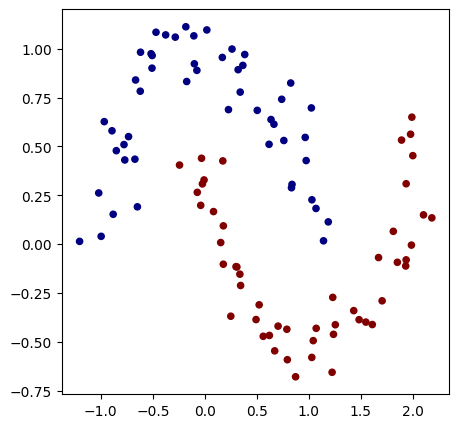

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [3]:
from nitty_gitty import Tensor

In [4]:
import torch

class PyTorchModule:
    def zero_grad(self):
        for p in self.parameters():
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def parameters(self):
        return []



class PyTorchLayer(PyTorchModule):

    def __init__(self, nin, nout, **kwargs):
        self.W = torch.tensor(np.random.uniform(-1, 1, (nin, nout)), dtype=torch.float32, requires_grad=True)
        self.B = torch.zeros(nout, dtype=torch.float32, requires_grad=True)
        self.activate = torch.nn.functional.relu

    def __call__(self, x):
        out = (x @ self.W) + self.B
        return self.activate(out) if self.activate is not None else out

    def parameters(self):
        return [self.W, self.B]

    def __repr__(self):
        return "Layer_9"
    

class PyTorchMLP(PyTorchModule):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [PyTorchLayer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [5]:
def pytorch_loss(model, batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = torch.tensor(Xb, dtype=torch.float32)
    yb = torch.tensor(yb, dtype=torch.float32)

    yb = yb.reshape(-1, 1)
    scores = model(inputs)

    losses = (1 + -yb * scores).relu()
    data_loss = losses.sum() * (1.0 / Xb.shape[0])
    
    
    alpha = 1e-4
    
    reg_loss = alpha * sum((p*p).sum() for p in model.parameters())

    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = (yb > 0) == (scores > 0)
    return total_loss,  accuracy.sum() / accuracy.shape[0]


In [6]:
from nitty_gitty.nn.functional import relu

class Module:
    def zero_grad(self):
        for p in self.parameters():
            if p.grad is not None:
                p.zero_grad()

    def parameters(self):
        return []


class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.W = Tensor(np.random.uniform(-1, 1, (nin, nout)), dtype="float32", requires_grad=True)
        self.B = Tensor(np.zeros(nout), dtype="float32", requires_grad=True)
        self.activate = relu

    def __call__(self, x):
        out = (x @ self.W) + self.B
        return self.activate(out) if self.activate is not None else out

    def parameters(self):
        return [self.W, self.B]

    def __repr__(self):
        return "Layer_9"

In [7]:
class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [8]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network

print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer_9, Layer_9, Layer_9]
number of parameters 6


In [9]:
pytorch_model = PyTorchMLP(2, [16, 16, 1]) # 2-layer neural network

print(pytorch_model)
print("number of parameters", len(pytorch_model.parameters()))

MLP of [Layer_9, Layer_9, Layer_9]
number of parameters 6


In [10]:
from nitty_gitty.core.device import get_numpy_engine, get_cupy_engine, normalize_device, Device

In [11]:
for param_1, param_2 in zip(model.parameters(), pytorch_model.parameters()):
    engine = get_cupy_engine() if normalize_device(param_1.device) == Device.GPU else get_numpy_engine()
    param_1.data = engine.asarray(param_2.data.detach().tolist())

In [12]:
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = Tensor(Xb, dtype="float32")
    yb = Tensor(yb, dtype="float32")

    yb = yb.reshape(-1, 1)
    scores = model(inputs)

    losses = (1 + -yb * scores).relu()
    data_loss = losses.sum() * (1.0 / Xb.shape[0])
    
    
    alpha = 1e-4
    
    reg_loss = alpha * sum((p*p).sum() for p in model.parameters())


    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = (yb > 0) == (scores > 0)
    return total_loss,  accuracy.sum() / accuracy.shape[0]

total_loss, acc = loss()
print(total_loss.data, acc.data)

0.9196104 0.76


In [13]:
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    model.zero_grad()

    total_loss.backward()    
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    # for p in model.parameters():
    #     p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc.data*100}%")

step 0 loss 0.9196103811264038, accuracy 75.99999904632568%
step 1 loss 1.3591850996017456, accuracy 60.00000238418579%
step 2 loss 0.8366150259971619, accuracy 69.9999988079071%
step 3 loss 0.6845653653144836, accuracy 82.99999833106995%
step 4 loss 0.6797797679901123, accuracy 83.99999737739563%
step 5 loss 0.6943955421447754, accuracy 83.99999737739563%
step 6 loss 0.6735351085662842, accuracy 83.99999737739563%
step 7 loss 0.6814101934432983, accuracy 82.99999833106995%
step 8 loss 0.6817255020141602, accuracy 83.99999737739563%
step 9 loss 0.7024821043014526, accuracy 86.00000143051147%
step 10 loss 0.6805412769317627, accuracy 85.00000238418579%
step 11 loss 0.6748756170272827, accuracy 83.99999737739563%
step 12 loss 0.6740307211875916, accuracy 83.99999737739563%
step 13 loss 0.6735711693763733, accuracy 83.99999737739563%
step 14 loss 0.6728525757789612, accuracy 83.99999737739563%
step 15 loss 0.6722611784934998, accuracy 83.99999737739563%
step 16 loss 0.6718966364860535, ac

(-1.6782030699112047, 2.0717969300887953)

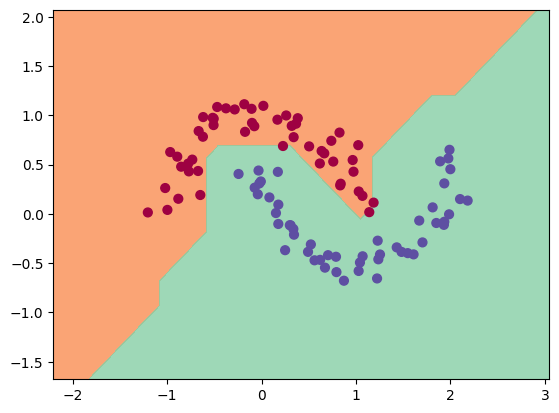

In [14]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor(Xmesh, dtype="float32")
scores = model(inputs)
Z = np.array(scores.data > 0)
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [15]:
for k in range(100):
    
    # forward
    total_loss, acc = pytorch_loss(pytorch_model)
    
    pytorch_model.zero_grad()
    total_loss.backward()    
    learning_rate = 1.0 - 0.9*k/100
    with torch.no_grad():
        for p in pytorch_model.parameters():
            p -= learning_rate * p.grad

    # for p in model.parameters():
    #     p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc.data*100}%")

step 0 loss 0.9196104407310486, accuracy 76.0%
step 1 loss 1.3591853380203247, accuracy 60.000003814697266%
step 2 loss 0.8366149663925171, accuracy 70.0%
step 3 loss 0.6845653653144836, accuracy 83.0%
step 4 loss 0.6797797679901123, accuracy 84.0%
step 5 loss 0.6943955421447754, accuracy 84.0%
step 6 loss 0.6735351085662842, accuracy 84.0%
step 7 loss 0.6814101934432983, accuracy 83.0%
step 8 loss 0.6817254424095154, accuracy 84.0%
step 9 loss 0.7024821043014526, accuracy 86.0%
step 10 loss 0.6805413365364075, accuracy 85.0%
step 11 loss 0.6748756170272827, accuracy 84.0%
step 12 loss 0.6740307211875916, accuracy 84.0%
step 13 loss 0.6735711693763733, accuracy 84.0%
step 14 loss 0.6728525757789612, accuracy 84.0%
step 15 loss 0.6722611784934998, accuracy 84.0%
step 16 loss 0.6718966364860535, accuracy 84.0%
step 17 loss 0.6710575819015503, accuracy 84.0%
step 18 loss 0.6691176295280457, accuracy 84.0%
step 19 loss 0.6725590825080872, accuracy 84.0%
step 20 loss 0.6739106178283691, acc

<Figure size 640x480 with 0 Axes>

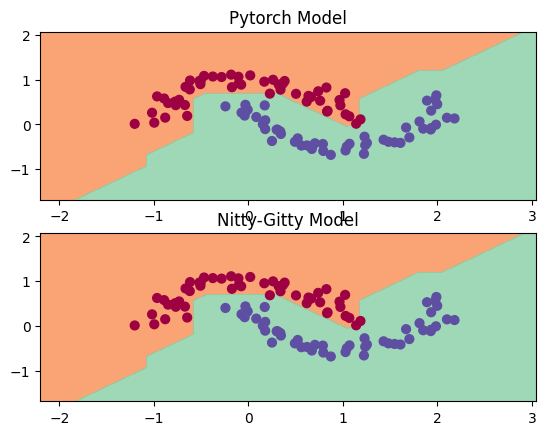

In [59]:
def get_prediction(model, input_module, dtype):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = input_module(Xmesh, dtype=dtype)    
    scores = model(inputs)
    Z = np.array(scores.data > 0)
    Z = Z.reshape(xx.shape)
    return xx, yy, Z


fig = plt.figure()
ax, bx = plt.subplots(2, 1)
xx, yy, Z = get_prediction(pytorch_model, torch.tensor, torch.float32)
bx[0].set_title("Pytorch Model")
bx[0].contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
bx[0].scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
bx[0].set_xlim(xx.min(), xx.max())
bx[0].set_ylim(yy.min(), yy.max())


bx[1].set_title("Nitty-Gitty Model")
xx, yy, Z = get_prediction(model, Tensor, "float32")
bx[1].contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
bx[1].scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
bx[1].set_xlim(xx.min(), xx.max())
bx[1].set_ylim(yy.min(), yy.max())

plt.show()

In [60]:
print("Weights still identical after training:", 
      all(torch.allclose(torch.tensor(p1.data, dtype=torch.float32), p2) for p1, p2 in zip(model.parameters(), pytorch_model.parameters())))

Weights still identical after training: True
